In [1]:
# util for SFG DRO
import torch
from sklearn.kernel_approximation import RBFSampler
from torch import nn
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import euclidean_distances
from torch.optim.swa_utils import AveragedModel  # average model weights
import torch.optim as optim



class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)

# This function builds the model for one-vs-all classification
def buildModel(task=None, method=None,n_hidden=100, device=None, loss_reduction='mean'):
    n_output = 1  # Only one output node for one-vs-all classification
    loss_erm = nn.BCEWithLogitsLoss(reduction=loss_reduction)  # Binary Cross-Entropy Loss
    
    # Defining the model architecture
    modelDecision = nn.Sequential(
        Flatten(), 
        nn.Linear(784, n_hidden), 
        nn.ReLU(), 
        nn.Linear(n_hidden, n_hidden), 
        nn.ReLU(), 
        nn.Linear(n_hidden, n_output)
    ).to(device)
    
    return modelDecision, loss_erm

def computeErr(yp, y,task=None,shuffle_test=False):
    predictions = (yp > 0).float()  # Converting model outputs to binary predictions
    err = (predictions != y).float().mean().item()  # Calculating the error rate
    return err





In [2]:
import numpy as np
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


def emnistData(task='one_vs_all', class_num=0, batch_size=100, shuffle_test=False, split='balanced'):
    # EMNIST has multiple splits like 'byclass', 'bymerge', 'balanced', 'letters', 'digits' and 'mnist'
    # 'balanced' split will give a balanced set of 47 classes of letters and digits
    
    # Check if class_num is within the valid range for the chosen split
    if split in ['byclass', 'bymerge']:
        num_classes = 47  # EMNIST byclass and bymerge have 47 classes
    elif split == 'balanced':
        num_classes = 47  # EMNIST balanced has 47 classes
    elif split == 'letters':
        num_classes = 26  # EMNIST letters has 26 classes (A-Z)
    elif split == 'digits':
        num_classes = 10  # EMNIST digits has 10 classes (0-9)
    elif split == 'mnist':
        num_classes = 10  # EMNIST mnist is the same as the original MNIST dataset

    if class_num < 0 or class_num >= num_classes:
        raise ValueError(f"class_num should be between 0 and {num_classes - 1}")

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    
    emnist_train = datasets.EMNIST("./data", split=split, train=True, download=True, transform=transform)
    emnist_test = datasets.EMNIST("./data", split=split, train=False, download=True, transform=transform)
    
    if task == 'one_vs_all':
        # Convert labels to a binary format (one vs all)
        emnist_train.targets = (emnist_train.targets == class_num).float()
        emnist_test.targets = (emnist_test.targets == class_num).float()

    train_loader = DataLoader(emnist_train, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(emnist_test, batch_size=batch_size, shuffle=shuffle_test)

    return train_loader, test_loader







In [3]:
def apply_gd(x, step_gamma=0.1):
    if x.grad is None:
        return x
    xnew = x - step_gamma * x.grad.detach()
    x.grad.data.zero_()
    return xnew


# a general loss function
def loss_general_se(output, target):
    return torch.sum((output - target) ** 2, dim=1).reshape(-1, 1)


def sample_zeta(X, y, zeta_sample_method=None, loss_erm=None, modelDecision=None, n_sample_zeta=1, epsilon_attack=0.0, learn_task=None, F=None):
    Z = None
    yperturb = None

    for _ in range(n_sample_zeta):
        delta = zeta_sample_method(loss_erm, modelDecision, X, y, randomize=True, epsilon=epsilon_attack,
                                   alpha=0.01, num_iter=20, task=learn_task, mklF=F)  # used with the new pgd
        # delta = attack(loss_erm, modelDecision, X, y, randomize=True, epsilon=1.0, alpha=0.01, num_iter=20, task=learn_task, rkhsF=F) # used with the new pgd

        Zperturb = X + delta
        if Z is not None:  # also penalize the original loss at unperturbed data
            Z = torch.cat((Zperturb, Z))  # cat new perturb Z with the old
            yperturb = torch.cat((yperturb, y))
        else:
            Z = Zperturb
            yperturb = y

    return Z, yperturb

In [4]:
def sfg_train_step(X=None, y=None, just_rand=None, loss_erm=None, modelDecision=None, n_sample_zeta=None, epsilon_attack=None,
                   learn_task=None, F=None, epsilon=None, stat_plot=None, i_decay_csa=None, is_step_const=None,
                   model_class=None, modelSWA=None):
    Z, y = sample_zeta(X, y, zeta_sample_method=just_rand, loss_erm=loss_erm,
                       modelDecision=modelDecision, n_sample_zeta=n_sample_zeta,
                       epsilon_attack=epsilon_attack, learn_task=learn_task, F=F)
    yp = evalutateErmModel(modelDecision, Z,
                           task=learn_task)  # use original model in ERM to run thru data X
    # kdro surrogate loss
    f_emp = torch.mean(F(X, fit=True))  # emp loss under emp loss
    # '''KDRO obj'''
    obj = f_emp + epsilon * F.norm()  # obj of the optimization problem
    #  original loss l eval on z
    loss_emp = loss_erm(yp, y).reshape(-1, 1)
    assert loss_emp.shape == F(Z).shape
    cons_sip = loss_emp - F(Z)  # constraint function of SIP. G(th, zeta)
    partial_moment = 1
    if partial_moment:  # use functional constr: E h(l-f) = 0
        max_cons_g = torch.mean(torch.nn.functional.relu(cons_sip))
    else:
        max_cons_g, id_max = torch.max(cons_sip, 0)  # max of violation across all samples zeta
    # bookeeping
    stat_plot["max_cons_violation"].append(max_cons_g.data.detach())
    stat_plot["obj"].append(obj.data.detach())

    '''CSA - SGD step size'''
    # threshold
    threshold_csa = 0.1 / np.sqrt(i_decay_csa + 1)  # decay threhold
    # threshold_csa = 0.01 # constant step
    # step size
    if is_step_const:
        step_csa = 0.01
    else:
        step_csa = 0.1 / np.sqrt(i_decay_csa + 1)  # decay threhold
    i_decay_csa += 1
    # %% update dec var: th, f0, f
    # zero gradient before backward
    try:
        for w in modelDecision.parameters(): w.grad.data.zero_()
        for w in F.model.parameters(): w.grad.data.zero_()
    except:
        pass
    if max_cons_g <= threshold_csa:  # if constr satisfied
        obj.backward()
        # there is no th update since obj doens't have th in it

        # %% if cons. satisfied, polyak averaging to keep track of average
        if model_class == 'mlp':
            modelSWA.update_parameters(modelDecision)  # model with averaged weights
            # pass
        else:
            raise NotImplementedError

    else:  # cons violation
        if partial_moment:
            max_cons_g.backward()  # diff this:  E h(l-f)
        else:
            cons_sip[id_max].backward()

        # update model var
        if model_class == 'mlp':
            for weight in modelDecision.parameters():
                weight.data = apply_gd(weight, step_csa)
        else:
            raise NotImplementedError
    # update f0, weights of f
    for weight in F.model.parameters():
        weight.data = apply_gd(weight, step_csa)
    return i_decay_csa, stat_plot


In [5]:
def run_test(test_loader, modelERM, loss_erm, loaded, attack_function=None, attack_range=None, task=None, n_test=100, device=None):
    D = {'err': [], 'attack': [], 'sig': []}
    for attack_strength in attack_range:
        i_test = 0

        err_this_attack = []
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            if task=='binary' or task=='one_vs_all':
                y = y.float()
            i_test += 1
            if i_test > n_test:
                break

            delta = attack_function(loss_erm, modelERM, X, y, attack_strength, task=task)

            # evaluate attack
            #         plt.figure()
            yp = evalutateErmModel(loaded['model'], X + delta, task=task)
            err_kdro = computeErr(yp, y, task=task)

            err_this_attack.append(deepcopy(err_kdro))

        # for each attack, compute average
        D['err'].append(np.mean(err_this_attack))
        D['sig'].append(np.std(err_this_attack))
        D['attack'].append(attack_strength)

    D['n_run'] = len(err_this_attack)  # total number of runs
    D['eps_dro'] = loaded['epsilon']
    D['is_erm'] = loaded['is_erm']
    try:
        D['is_pgd'] = loaded['is_pgd']
    except:
        pass

    D['task'] = task

    return D



In [6]:
def evalutateErmModel(modelDecision, X, task=None):
    yp = modelDecision(X.view(X.shape[0], -1)).squeeze()  # No need for indexing in one-vs-all
    return yp







In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as Fa

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

class MKLfunction(nn.Module):
    def __init__(self, input_shape, model=None, gamma=None, degree=3, coef0=1, kernel_list=None):
        super(MKLfunction, self).__init__()
        self.model = model
        self.input_shape = input_shape
        self.gamma = gamma
        self.degree = degree
        self.coef0 = coef0
        
        self.flatten = Flatten()  # Instantiate the Flatten module
        self.kernel_list = kernel_list or [self.rbf_kernel_torch, self.polynomial_kernel_torch]
        self.kernel_weights = nn.Parameter(torch.ones(len(self.kernel_list)), requires_grad=True)

    def rbf_kernel_torch(self, X, Y=None):
        X = self.flatten(X)
        Y = self.flatten(Y) if Y is not None else X
        gamma = self.gamma if self.gamma is not None else 1.0 / X.size(1)
        
        sq_norms_X = torch.sum(X**2, dim=1)
        sq_norms_Y = torch.sum(Y**2, dim=1)
        cross_products = torch.mm(X, Y.t())
        distances = sq_norms_X[:, None] + sq_norms_Y[None, :] - 2 * cross_products
        return torch.exp(-gamma * distances)

    def polynomial_kernel_torch(self, X, Y=None):
        X = self.flatten(X)
        Y = self.flatten(Y) if Y is not None else X
        products = torch.mm(X, Y.t())
        return (products + self.coef0)**self.degree

    def compute_combined_kernel(self, X):
        X_tensor = X.clone().detach().requires_grad_(True)
        kernel_matrices = [k(X_tensor) for k in self.kernel_list]
        normalized_weights = Fa.softmax(self.kernel_weights, dim=0)
        K_combined = sum(w * km for w, km in zip(normalized_weights, kernel_matrices))
        return K_combined

    def forward(self, X, fit=False):
        K_combined = self.compute_combined_kernel(X)
        
        # Ensure that the model is correctly defined for the shape of K_combined
        if self.model is None or self.model[1].in_features != K_combined.shape[1]:
            self.model = nn.Sequential(Flatten(), nn.Linear(K_combined.shape[1], 1, bias=True))

        mklF = self.model(K_combined)
        return mklF

    def norm(self):
        return torch.norm(self.kernel_weights)



In [8]:
def pgd_linf(loss_attack, model, X, y, epsilon=1.0, alpha=0.01, num_iter=20, randomize=False, task=None):
    """ Construct PGD adversarial examples on the examples X"""
    if randomize:
        delta = torch.rand_like(X, requires_grad=True)
        delta.data = delta.data * 2 * epsilon - epsilon
    else:
        delta = torch.zeros_like(X, requires_grad=True)

    for t in range(num_iter):
        loss = loss_attack(evalutateErmModel(model, X + delta, task=task), y)
        if loss.numel() != 1:  # This is to check if the tensor is not a scalar
            loss = loss.sum()  # Or use mean(), depending on your specific requirements
        loss.backward()

        delta.data = (delta + alpha * delta.grad.detach().sign()).clamp(-epsilon, epsilon)
        delta.grad.zero_()

    # for w in model.parameters(): w.grad.data.zero_()
        # for w in rkhsF.model.parameters(): w.grad.data.zero_()
    return delta.detach()


def just_rand(loss_attack, model, X, y, epsilon=1.0, alpha=0.01, num_iter=20, randomize=False, task=None, **kwargs):
    """ just use random noises to sample new samples"""
    delta = torch.rand_like(X, requires_grad=False)
    delta.data = 2* (delta.data - 0.5) * epsilon

    return delta.detach()

In [9]:
# params
n_epoch_gd = 10# how many epochs of SFG to run
learn_task = 'one_vs_all'
mini_batch = 20 
model_class = 'mlp'
loss_reduction = 'none'
n_rand_feat = 500
n_sample_zeta = 150
epsilon_attack = 0.5  # largest perturbation of the domain allowed in RO
epsilon = 1.0  # Kernel DRO ambiguity size
is_step_const = 0  # use decay step size
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set up
train_loader, test_loader = emnistData(task=learn_task, batch_size=mini_batch,split='balanced')
modelDecision, loss_erm = buildModel(task=learn_task, method=model_class, n_hidden=64, device=device,
                                     loss_reduction=loss_reduction)
modelSWA = AveragedModel(modelDecision)


X_initial, y_initial = next(iter(train_loader))
X_initial = X_initial.requires_grad_(True).to(device)

# Define the model to be used within MKLfunction
input_features = X_initial.shape[1] * X_initial.shape[2] * X_initial.shape[3]
mkl_model = nn.Sequential(
    Flatten(),
    nn.Linear(input_features, 96),  # Adjust the output features as needed
    nn.ReLU(),
    nn.Linear(96, 1)
).to(device)

# Instantiate the MKLfunction with the newly defined model
F = MKLfunction(X_initial.shape, model=mkl_model)
# Bookkeeping
stat_plot = {"max_cons_violation": [], "obj": []}

In [10]:
from tqdm import tqdm

print("=========Training SFG DRO=========")

i_decay_csa = 0  # counter for threshold decay

# Wrapping the range function with tqdm to get progress bar for epochs
for i_epoch in tqdm(range(n_epoch_gd), desc="Epochs"):
    # Wrapping the train_loader with tqdm to get progress bar for batches
    for X, y in tqdm(train_loader, desc="Batches", leave=False):
        X, y = X.to(device), y.to(device)
        if learn_task=='binary' or learn_task=='one_vs_all':
            y = y.float()

        i_decay_csa, stat_plot = sfg_train_step(X=X, y=y, just_rand=just_rand, loss_erm=loss_erm,
                                                modelDecision=modelDecision, n_sample_zeta=n_sample_zeta,
                                                epsilon_attack=epsilon_attack,
                                                learn_task=learn_task, F=F, epsilon=epsilon, stat_plot=stat_plot,
                                                i_decay_csa=i_decay_csa,
                                                is_step_const=is_step_const,
                                                model_class=model_class, modelSWA=modelSWA)
    print('epoch:', i_epoch, '/', n_epoch_gd)

print("=========Training Finished=========")

=========Training SFG DRO=========


Batches:   2%|▏         | 126/5640 [05:30<4:21:45,  2.85s/it]


Batches:   4%|▍         | 252/5640 [12:08<4:30:47,  3.02s/it]


Batches:   7%|▋         | 378/5640 [18:40<4:37:58,  3.17s/it]


Batches:   9%|▉         | 504/5640 [25:10<4:08:55,  2.91s/it]


Batches:  11%|█         | 630/5640 [31:51<4:23:38,  3.16s/it]


Batches:  13%|█▎        | 756/5640 [38:12<4:24:07,  3.24s/it]


Batches:  16%|█▌        | 882/5640 [44:29<3:49:23,  2.89s/it]


Batches:  18%|█▊        | 1007/5640 [50:58<4:03:23,  3.15s/it]


Batches:  20%|██        | 1131/5640 [56:52<3:31:08,  2.81s/it]


Batches:  22%|██▏       | 1253/5640 [1:02:35<3:25:03,  2.80s/it]


Batches:  24%|██▍       | 1373/5640 [1:08:13<3:20:07,  2.81s/it]


Batches:  26%|██▋       | 1493/5640 [1:13:50<3:15:02,  2.82s/it]


Batches:  29%|██▊       | 1613/5640 [1:19:29<3:08:42,  2.81s/it]


Batches:  31%|███       | 1733/5640 [1:25:07<3:07:19,  2.88s/it]


Batches:  33%|███▎      | 1853/5640 [1:30:48<3:00:05,  2.85s/it]


Batches:  35%|███▍      | 1973/5640 [1:36:55<3:23:53,  3.34s/it]


Batches:  37%|███▋      | 2093/5640 [1:43:47<3:22:15,  3.42s/it]


Batches:  39%|███▉      | 2213/5640 [1:50:07<2:46:59,  2.92s/it]


Batches:  41%|████▏     | 2333/5640 [1:56:32<3:06:07,  3.38s/it]


Batches:  43%|████▎     | 2453/5640 [2:02:33<2:52:26,  3.25s/it]


Batches:  46%|████▌     | 2573/5640 [2:09:13<2:42:46,  3.18s/it]


Batches:  48%|████▊     | 2693/5640 [2:15:05<2:19:21,  2.84s/it]


Batches:  50%|████▉     | 2813/5640 [2:20:57<2:14:25,  2.85s/it]


Batches:  52%|█████▏    | 2933/5640 [2:26:38<2:19:13,  3.09s/it]


Batches:  54%|█████▍    | 3053/5640 [2:32:44<2:07:28,  2.96s/it]


Batches:  56%|█████▋    | 3173/5640 [2:38:40<2:01:30,  2.96s/it]


Batches:  58%|█████▊    | 3293/5640 [2:44:28<1:49:57,  2.81s/it]


Batches:  61%|██████    | 3413/5640 [2:50:06<1:44:24,  2.81s/it]


Batches:  63%|██████▎   | 3533/5640 [2:55:45<1:38:03,  2.79s/it]


Batches:  65%|██████▍   | 3653/5640 [3:01:30<1:35:01,  2.87s/it]


Batches:  67%|██████▋   | 3773/5640 [3:07:23<1:27:59,  2.83s/it]


Batches:  69%|██████▉   | 3893/5640 [3:13:20<1:30:14,  3.10s/it]


Batches:  71%|███████   | 4013/5640 [3:19:07<1:17:49,  2.87s/it]


Batches:  73%|███████▎  | 4133/5640 [3:24:57<1:11:08,  2.83s/it]


Batches:  75%|███████▌  | 4253/5640 [3:30:55<1:05:18,  2.83s/it]


Batches:  78%|███████▊  | 4373/5640 [3:36:45<1:02:44,  2.97s/it]


Batches:  80%|███████▉  | 4495/5640 [3:42:50<55:39,  2.92s/it]


Batches:  82%|████████▏ | 4619/5640 [3:48:58<53:01,  3.12s/it]


Batches:  84%|████████▍ | 4743/5640 [3:55:19<44:00,  2.94s/it]


Batches:  86%|████████▋ | 4867/5640 [4:01:51<44:25,  3.45s/it]


Batches:  88%|████████▊ | 4991/5640 [4:08:37<31:49,  2.94s/it]


Batches:  91%|█████████ | 5115/5640 [4:14:43<25:12,  2.88s/it]


Batches:  93%|█████████▎| 5239/5640 [4:20:50<19:01,  2.85s/it]


Batches:  95%|█████████▌| 5363/5640 [4:26:43<13:18,  2.88s/it]


Batches:  97%|█████████▋| 5487/5640 [4:32:35<07:11,  2.82s/it]


Batches:  99%|█████████▉| 5611/5640 [4:38:28<01:22,  2.84s/it]


Epochs:  10%|█         | 1/10 [4:39:50<41:58:33, 16790.39s/it]

epoch: 0 / 10



Batches:   2%|▏         | 126/5640 [05:57<4:18:45,  2.82s/it]


Batches:   4%|▍         | 252/5640 [11:54<4:15:19,  2.84s/it]


Batches:   7%|▋         | 378/5640 [17:53<4:10:59,  2.86s/it]


Batches:   9%|▉         | 504/5640 [23:52<4:05:32,  2.87s/it]


Batches:  11%|█         | 630/5640 [29:50<3:57:13,  2.84s/it]


Batches:  13%|█▎        | 756/5640 [35:48<3:52:35,  2.86s/it]


Batches:  16%|█▌        | 882/5640 [42:21<3:56:26,  2.98s/it]


Batches:  18%|█▊        | 1007/5640 [48:27<3:39:00,  2.84s/it]


Batches:  20%|██        | 1131/5640 [54:39<3:46:43,  3.02s/it]


Batches:  22%|██▏       | 1254/5640 [1:00:31<3:53:52,  3.20s/it]


Batches:  24%|██▍       | 1374/5640 [1:06:25<3:26:57,  2.91s/it]


Batches:  26%|██▋       | 1494/5640 [1:12:16<3:15:54,  2.84s/it]


Batches:  29%|██▊       | 1614/5640 [1:17:54<3:09:59,  2.83s/it]


Batches:  31%|███       | 1734/5640 [1:23:30<3:00:25,  2.77s/it]


Batches:  33%|███▎      | 1854/5640 [1:29:07<2:57:08,  2.81s/it]


Batches:  35%|███▌      | 1974/5640 [1:34:44<2:51:39,  2.81s/it]


Batches:  37%|███▋      | 2094/5640 [1:40:22<2:45:55,  2.81s/it]


Batches:  39%|███▉      | 2214/5640 [1:46:02<2:41:23,  2.83s/it]


Batches:  41%|████▏     | 2334/5640 [1:51:40<2:33:24,  2.78s/it]


Batches:  44%|████▎     | 2454/5640 [1:57:16<2:28:16,  2.79s/it]


Batches:  46%|████▌     | 2574/5640 [2:02:53<2:23:42,  2.81s/it]


Batches:  48%|████▊     | 2694/5640 [2:08:29<2:17:30,  2.80s/it]


Batches:  50%|████▉     | 2814/5640 [2:14:06<2:11:41,  2.80s/it]


Batches:  52%|█████▏    | 2934/5640 [2:19:43<2:05:22,  2.78s/it]


Batches:  54%|█████▍    | 3054/5640 [2:25:19<2:00:35,  2.80s/it]


Batches:  56%|█████▋    | 3174/5640 [2:30:55<1:55:01,  2.80s/it]


Batches:  58%|█████▊    | 3294/5640 [2:36:32<1:48:52,  2.78s/it]


Batches:  61%|██████    | 3414/5640 [2:42:08<1:43:53,  2.80s/it]


Batches:  63%|██████▎   | 3534/5640 [2:47:45<1:38:22,  2.80s/it]


Batches:  65%|██████▍   | 3654/5640 [2:53:21<1:34:17,  2.85s/it]


Batches:  67%|██████▋   | 3774/5640 [2:58:58<1:27:05,  2.80s/it]


Batches:  69%|██████▉   | 3894/5640 [3:04:35<1:21:38,  2.81s/it]


Batches:  71%|███████   | 4014/5640 [3:10:11<1:15:35,  2.79s/it]


Batches:  73%|███████▎  | 4134/5640 [3:15:48<1:10:19,  2.80s/it]


Batches:  75%|███████▌  | 4254/5640 [3:21:25<1:04:26,  2.79s/it]


Batches:  78%|███████▊  | 4374/5640 [3:27:01<58:42,  2.78s/it]


Batches:  80%|███████▉  | 4498/5640 [3:32:48<53:36,  2.82s/it]


Batches:  82%|████████▏ | 4622/5640 [3:38:36<47:16,  2.79s/it]


Batches:  84%|████████▍ | 4746/5640 [3:44:23<41:47,  2.80s/it]


Batches:  86%|████████▋ | 4870/5640 [3:50:11<36:29,  2.84s/it]


Batches:  89%|████████▊ | 4994/5640 [3:55:59<30:16,  2.81s/it]


Batches:  91%|█████████ | 5118/5640 [4:01:47<24:19,  2.80s/it]


Batches:  93%|█████████▎| 5242/5640 [4:07:35<18:44,  2.83s/it]


Batches:  95%|█████████▌| 5366/5640 [4:13:22<12:51,  2.82s/it]


Batches:  97%|█████████▋| 5490/5640 [4:19:09<07:02,  2.81s/it]


Batches: 100%|█████████▉| 5614/5640 [4:24:57<01:12,  2.79s/it]


Epochs:  20%|██        | 2/10 [9:06:00<36:14:24, 16308.12s/it]

epoch: 1 / 10



Batches:   2%|▏         | 126/5640 [05:52<4:19:40,  2.83s/it]


Batches:   4%|▍         | 252/5640 [11:46<4:14:41,  2.84s/it]


Batches:   7%|▋         | 378/5640 [17:39<4:09:33,  2.85s/it]


Batches:   9%|▉         | 504/5640 [23:34<4:01:10,  2.82s/it]


Batches:  11%|█         | 630/5640 [29:28<3:52:13,  2.78s/it]


Batches:  13%|█▎        | 756/5640 [35:22<3:48:13,  2.80s/it]


Batches:  16%|█▌        | 882/5640 [41:15<3:42:17,  2.80s/it]


Batches:  18%|█▊        | 1007/5640 [47:05<3:35:02,  2.78s/it]


Batches:  20%|██        | 1131/5640 [52:53<3:30:31,  2.80s/it]


Batches:  22%|██▏       | 1255/5640 [58:40<3:26:55,  2.83s/it]


Batches:  24%|██▍       | 1376/5640 [1:04:20<3:18:20,  2.79s/it]


Batches:  27%|██▋       | 1496/5640 [1:09:57<3:13:28,  2.80s/it]


Batches:  29%|██▊       | 1616/5640 [1:15:34<3:08:32,  2.81s/it]


Batches:  31%|███       | 1736/5640 [1:22:00<3:56:03,  3.63s/it]


Batches:  33%|███▎      | 1856/5640 [1:29:16<3:39:07,  3.47s/it]


Batches:  35%|███▌      | 1976/5640 [1:35:15<2:59:13,  2.94s/it]


Batches:  37%|███▋      | 2096/5640 [1:41:24<3:47:56,  3.86s/it]


Batches:  39%|███▉      | 2216/5640 [1:48:36<3:17:59,  3.47s/it]


Batches:  41%|████▏     | 2336/5640 [1:55:35<2:48:39,  3.06s/it]


Batches:  44%|████▎     | 2456/5640 [2:01:27<2:35:24,  2.93s/it]


Batches:  46%|████▌     | 2576/5640 [2:07:19<2:30:20,  2.94s/it]


Batches:  48%|████▊     | 2696/5640 [2:13:11<2:23:58,  2.93s/it]


Batches:  50%|████▉     | 2816/5640 [2:19:03<2:20:07,  2.98s/it]


Batches:  52%|█████▏    | 2936/5640 [2:24:55<2:11:14,  2.91s/it]


Batches:  54%|█████▍    | 3056/5640 [2:30:46<2:08:03,  2.97s/it]


Batches:  56%|█████▋    | 3176/5640 [2:36:40<2:00:55,  2.94s/it]


Batches:  58%|█████▊    | 3296/5640 [2:42:31<1:53:59,  2.92s/it]


Batches:  61%|██████    | 3416/5640 [2:48:22<1:49:09,  2.94s/it]


Batches:  63%|██████▎   | 3536/5640 [2:54:13<1:43:54,  2.96s/it]


Batches:  65%|██████▍   | 3656/5640 [3:00:04<1:37:45,  2.96s/it]


Batches:  67%|██████▋   | 3776/5640 [3:05:56<1:30:38,  2.92s/it]


Batches:  69%|██████▉   | 3896/5640 [3:11:47<1:24:53,  2.92s/it]


Batches:  71%|███████   | 4016/5640 [3:17:39<1:19:03,  2.92s/it]


Batches:  73%|███████▎  | 4136/5640 [3:23:31<1:14:30,  2.97s/it]


Batches:  75%|███████▌  | 4256/5640 [3:29:23<1:07:56,  2.95s/it]


Batches:  78%|███████▊  | 4376/5640 [3:35:14<1:01:44,  2.93s/it]


Batches:  80%|███████▉  | 4499/5640 [3:41:14<55:37,  2.93s/it]


Batches:  82%|████████▏ | 4623/5640 [3:47:17<49:52,  2.94s/it]


Batches:  84%|████████▍ | 4747/5640 [3:53:20<43:41,  2.94s/it]


Batches:  86%|████████▋ | 4871/5640 [3:59:24<37:15,  2.91s/it]


Batches:  89%|████████▊ | 4995/5640 [4:05:27<31:24,  2.92s/it]


Batches:  91%|█████████ | 5119/5640 [4:11:30<25:27,  2.93s/it]


Batches:  93%|█████████▎| 5243/5640 [4:17:32<19:11,  2.90s/it]


Batches:  95%|█████████▌| 5367/5640 [4:23:36<13:19,  2.93s/it]


Batches:  97%|█████████▋| 5491/5640 [4:29:39<07:19,  2.95s/it]


Batches: 100%|█████████▉| 5615/5640 [4:35:42<01:12,  2.91s/it]


Epochs:  30%|███       | 3/10 [13:42:56<31:59:00, 16448.64s/it][A

epoch: 2 / 10



Batches:   2%|▏         | 126/5640 [06:08<4:29:44,  2.94s/it]


Batches:   4%|▍         | 252/5640 [12:17<4:25:51,  2.96s/it]


Batches:   7%|▋         | 378/5640 [18:27<4:16:13,  2.92s/it]


Batches:   9%|▉         | 504/5640 [24:36<4:11:21,  2.94s/it]


Batches:  11%|█         | 630/5640 [30:49<4:05:12,  2.94s/it]


Batches:  13%|█▎        | 756/5640 [37:01<4:00:12,  2.95s/it]


Batches:  16%|█▌        | 882/5640 [43:14<3:53:52,  2.95s/it]


Batches:  18%|█▊        | 1007/5640 [49:24<3:47:45,  2.95s/it]


Batches:  20%|██        | 1131/5640 [55:31<3:42:05,  2.96s/it]


Batches:  22%|██▏       | 1254/5640 [1:01:31<3:31:39,  2.90s/it]


Batches:  24%|██▍       | 1374/5640 [1:07:09<3:08:09,  2.65s/it]


Batches:  26%|██▋       | 1494/5640 [1:12:14<2:55:50,  2.54s/it]


Batches:  29%|██▊       | 1614/5640 [1:17:18<2:50:19,  2.54s/it]


Batches:  31%|███       | 1734/5640 [1:22:23<2:44:26,  2.53s/it]


Batches:  33%|███▎      | 1854/5640 [1:27:27<2:39:59,  2.54s/it]


Batches:  35%|███▌      | 1974/5640 [1:31:51<2:13:36,  2.19s/it]


Batches:  37%|███▋      | 2094/5640 [1:36:10<2:06:24,  2.14s/it]


Batches:  39%|███▉      | 2214/5640 [1:40:29<2:05:13,  2.19s/it]


Batches:  41%|████▏     | 2334/5640 [1:44:49<2:00:01,  2.18s/it]


Batches:  44%|████▎     | 2454/5640 [1:49:08<1:54:08,  2.15s/it]


Batches:  46%|████▌     | 2574/5640 [1:53:37<1:52:39,  2.20s/it]


Batches:  48%|████▊     | 2694/5640 [1:58:04<1:48:40,  2.21s/it]


Batches:  50%|████▉     | 2814/5640 [2:02:31<1:44:11,  2.21s/it]


Batches:  52%|█████▏    | 2934/5640 [2:07:12<1:48:11,  2.40s/it]


Batches:  54%|█████▍    | 3054/5640 [2:11:55<1:36:23,  2.24s/it]


Batches:  56%|█████▋    | 3174/5640 [2:16:24<1:29:36,  2.18s/it]


Batches:  58%|█████▊    | 3294/5640 [2:20:52<1:28:06,  2.25s/it]


Batches:  61%|██████    | 3414/5640 [2:25:17<1:21:34,  2.20s/it]


Batches:  63%|██████▎   | 3534/5640 [2:29:45<1:18:06,  2.23s/it]


Batches:  65%|██████▍   | 3654/5640 [2:34:10<1:10:14,  2.12s/it]


Batches:  67%|██████▋   | 3774/5640 [2:38:28<1:06:30,  2.14s/it]


Batches:  69%|██████▉   | 3894/5640 [2:42:46<1:02:07,  2.13s/it]


Batches:  71%|███████   | 4015/5640 [2:47:07<58:51,  2.17s/it]


Batches:  73%|███████▎  | 4139/5640 [2:51:34<53:40,  2.15s/it]


Batches:  76%|███████▌  | 4263/5640 [2:56:02<49:42,  2.17s/it]


Batches:  78%|███████▊  | 4387/5640 [3:00:28<44:47,  2.15s/it]


Batches:  80%|███████▉  | 4511/5640 [3:04:56<40:38,  2.16s/it]


Batches:  82%|████████▏ | 4635/5640 [3:09:23<35:55,  2.14s/it]


Batches:  84%|████████▍ | 4759/5640 [3:13:51<32:06,  2.19s/it]


Batches:  87%|████████▋ | 4883/5640 [3:18:19<27:14,  2.16s/it]


Batches:  89%|████████▉ | 5007/5640 [3:22:47<22:41,  2.15s/it]


Batches:  91%|█████████ | 5131/5640 [3:27:15<18:23,  2.17s/it]


Batches:  93%|█████████▎| 5255/5640 [3:31:42<14:02,  2.19s/it]


Batches:  95%|█████████▌| 5379/5640 [3:36:10<09:27,  2.18s/it]


Batches:  98%|█████████▊| 5503/5640 [3:40:38<04:50,  2.12s/it]


Batches: 100%|█████████▉| 5627/5640 [3:45:05<00:27,  2.15s/it]


Epochs:  40%|████      | 4/10 [17:28:30<25:29:48, 15298.03s/it][A

epoch: 3 / 10



Batches:   2%|▏         | 126/5640 [04:32<3:17:31,  2.15s/it]


Batches:   4%|▍         | 252/5640 [09:04<3:14:11,  2.16s/it]


Batches:   7%|▋         | 378/5640 [13:36<3:09:45,  2.16s/it]


Batches:   9%|▉         | 504/5640 [18:08<3:06:11,  2.18s/it]


Batches:  11%|█         | 630/5640 [22:40<3:02:34,  2.19s/it]


Batches:  13%|█▎        | 756/5640 [27:12<2:55:14,  2.15s/it]


Batches:  16%|█▌        | 882/5640 [31:44<2:51:36,  2.16s/it]


Batches:  18%|█▊        | 1007/5640 [36:13<2:44:18,  2.13s/it]


Batches:  20%|██        | 1131/5640 [40:42<2:41:43,  2.15s/it]


Batches:  22%|██▏       | 1255/5640 [45:09<2:40:52,  2.20s/it]


Batches:  24%|██▍       | 1379/5640 [49:36<2:31:54,  2.14s/it]


Batches:  27%|██▋       | 1503/5640 [54:04<2:27:51,  2.14s/it]


Batches:  29%|██▉       | 1627/5640 [58:33<2:23:35,  2.15s/it]


Batches:  31%|███       | 1748/5640 [1:02:54<2:18:19,  2.13s/it]


Batches:  33%|███▎      | 1868/5640 [1:07:12<2:13:02,  2.12s/it]


Batches:  35%|███▌      | 1988/5640 [1:11:34<2:10:59,  2.15s/it]


Batches:  37%|███▋      | 2108/5640 [1:15:53<2:07:33,  2.17s/it]


Batches:  40%|███▉      | 2228/5640 [1:20:12<2:02:03,  2.15s/it]


Batches:  42%|████▏     | 2348/5640 [1:24:30<1:56:33,  2.12s/it]


Batches:  44%|████▍     | 2468/5640 [1:28:48<1:52:19,  2.12s/it]


Batches:  46%|████▌     | 2588/5640 [1:33:12<1:49:54,  2.16s/it]


Batches:  48%|████▊     | 2708/5640 [1:37:30<1:45:42,  2.16s/it]


Batches:  50%|█████     | 2828/5640 [1:41:50<1:40:47,  2.15s/it]


Batches:  52%|█████▏    | 2948/5640 [1:46:09<1:38:36,  2.20s/it]


Batches:  54%|█████▍    | 3068/5640 [1:50:29<1:33:08,  2.17s/it]


Batches:  57%|█████▋    | 3188/5640 [1:54:48<1:28:59,  2.18s/it]


Batches:  59%|█████▊    | 3308/5640 [1:59:08<1:24:56,  2.19s/it]


Batches:  61%|██████    | 3428/5640 [2:03:27<1:17:23,  2.10s/it]


Batches:  63%|██████▎   | 3548/5640 [2:07:47<1:16:35,  2.20s/it]


Batches:  65%|██████▌   | 3668/5640 [2:12:05<1:09:52,  2.13s/it]


Batches:  67%|██████▋   | 3788/5640 [2:16:24<1:06:00,  2.14s/it]


Batches:  69%|██████▉   | 3908/5640 [2:20:43<1:02:26,  2.16s/it]


Batches:  71%|███████▏  | 4030/5640 [2:25:06<58:36,  2.18s/it]


Batches:  74%|███████▎  | 4154/5640 [2:29:33<52:56,  2.14s/it]


Batches:  76%|███████▌  | 4278/5640 [2:34:01<49:16,  2.17s/it]


Batches:  78%|███████▊  | 4402/5640 [2:38:30<44:44,  2.17s/it]


Batches:  80%|████████  | 4526/5640 [2:42:59<40:18,  2.17s/it]


Batches:  82%|████████▏ | 4650/5640 [2:47:27<35:59,  2.18s/it]


Batches:  85%|████████▍ | 4774/5640 [2:51:55<30:48,  2.13s/it]


Batches:  87%|████████▋ | 4898/5640 [2:56:22<27:15,  2.20s/it]


Batches:  89%|████████▉ | 5022/5640 [3:00:51<22:20,  2.17s/it]


Batches:  91%|█████████ | 5146/5640 [3:05:18<17:26,  2.12s/it]


Batches:  93%|█████████▎| 5270/5640 [3:09:44<13:13,  2.14s/it]


Batches:  96%|█████████▌| 5394/5640 [3:14:11<08:55,  2.18s/it]


Batches:  98%|█████████▊| 5518/5640 [3:18:38<04:23,  2.16s/it]


Epochs:  50%|█████     | 5/10 [20:51:55<19:41:52, 14182.49s/it][A

epoch: 4 / 10



Batches:   2%|▏         | 126/5640 [04:48<3:21:53,  2.20s/it]


Batches:   4%|▍         | 252/5640 [09:29<3:31:04,  2.35s/it]


Batches:   7%|▋         | 378/5640 [14:10<3:24:56,  2.34s/it]


Batches:   9%|▉         | 504/5640 [19:14<3:11:27,  2.24s/it]


Batches:  11%|█         | 630/5640 [24:03<3:01:16,  2.17s/it]


Batches:  13%|█▎        | 756/5640 [28:51<2:56:39,  2.17s/it]


Batches:  16%|█▌        | 882/5640 [33:42<3:23:25,  2.57s/it]


Batches:  18%|█▊        | 1007/5640 [38:33<2:54:35,  2.26s/it]


Batches:  20%|██        | 1131/5640 [43:14<2:48:33,  2.24s/it]


Batches:  22%|██▏       | 1255/5640 [48:06<2:55:21,  2.40s/it]


Batches:  24%|██▍       | 1379/5640 [54:30<4:43:44,  4.00s/it]


Batches:  27%|██▋       | 1502/5640 [1:02:19<4:21:08,  3.79s/it]


Batches:  29%|██▉       | 1622/5640 [1:09:58<4:11:15,  3.75s/it]


Batches:  31%|███       | 1742/5640 [1:17:38<4:14:17,  3.91s/it]


Batches:  33%|███▎      | 1862/5640 [1:25:21<4:07:32,  3.93s/it]


Batches:  35%|███▌      | 1982/5640 [1:33:09<4:02:15,  3.97s/it]


Batches:  37%|███▋      | 2102/5640 [1:41:11<3:56:20,  4.01s/it]


Batches:  39%|███▉      | 2222/5640 [1:49:04<3:43:30,  3.92s/it]


Batches:  42%|████▏     | 2342/5640 [1:56:54<3:33:00,  3.88s/it]


Batches:  44%|████▎     | 2462/5640 [2:04:48<3:19:27,  3.77s/it]


Batches:  46%|████▌     | 2582/5640 [2:12:46<3:22:45,  3.98s/it]


Batches:  48%|████▊     | 2702/5640 [2:20:38<3:11:50,  3.92s/it]


Batches:  50%|█████     | 2822/5640 [2:28:38<3:03:43,  3.91s/it]


Batches:  52%|█████▏    | 2942/5640 [2:36:36<2:57:34,  3.95s/it]


Batches:  54%|█████▍    | 3062/5640 [2:44:29<2:49:02,  3.93s/it]


Batches:  56%|█████▋    | 3182/5640 [2:52:20<2:39:31,  3.89s/it]


Batches:  59%|█████▊    | 3302/5640 [3:00:14<2:35:25,  3.99s/it]


Batches:  61%|██████    | 3422/5640 [3:08:08<2:27:43,  4.00s/it]


Batches:  63%|██████▎   | 3542/5640 [3:16:02<2:17:44,  3.94s/it]


Batches:  65%|██████▍   | 3662/5640 [3:23:56<2:12:15,  4.01s/it]


Batches:  67%|██████▋   | 3782/5640 [3:31:49<2:00:53,  3.90s/it]


Batches:  69%|██████▉   | 3902/5640 [3:39:43<1:54:44,  3.96s/it]


Batches:  71%|███████▏  | 4022/5640 [3:47:34<1:45:10,  3.90s/it]


Batches:  73%|███████▎  | 4142/5640 [3:55:26<1:38:58,  3.96s/it]


Batches:  76%|███████▌  | 4262/5640 [4:03:14<1:31:17,  3.97s/it]


Batches:  78%|███████▊  | 4382/5640 [4:11:09<1:23:34,  3.99s/it]


Batches:  80%|███████▉  | 4502/5640 [4:18:45<1:10:40,  3.73s/it]


Batches:  82%|████████▏ | 4622/5640 [4:26:18<1:04:08,  3.78s/it]


Batches:  84%|████████▍ | 4744/5640 [4:33:57<56:15,  3.77s/it]


Batches:  86%|████████▋ | 4868/5640 [4:41:49<48:45,  3.79s/it]


Batches:  89%|████████▊ | 4992/5640 [4:49:34<40:39,  3.76s/it]


Batches:  91%|█████████ | 5116/5640 [4:57:26<33:20,  3.82s/it]


Batches:  93%|█████████▎| 5240/5640 [5:05:12<25:13,  3.78s/it]


Batches:  95%|█████████▌| 5364/5640 [5:16:20<17:49,  3.87s/it]


Batches:  97%|█████████▋| 5488/5640 [5:24:24<09:38,  3.81s/it]


Batches: 100%|█████████▉| 5612/5640 [5:32:08<01:31,  3.28s/it]


Epochs:  60%|██████    | 6/10 [26:25:33<17:57:46, 16166.65s/it][A

epoch: 5 / 10



Batches:   2%|▏         | 126/5640 [07:55<7:15:18,  4.74s/it]


Batches:   4%|▍         | 252/5640 [15:43<5:13:45,  3.49s/it]


Batches:   7%|▋         | 378/5640 [23:46<6:10:03,  4.22s/it]


Batches:   9%|▉         | 504/5640 [30:55<5:19:56,  3.74s/it]


Batches:  11%|█         | 630/5640 [38:58<4:42:39,  3.39s/it]


Batches:  13%|█▎        | 756/5640 [46:26<4:59:08,  3.67s/it]


Batches:  16%|█▌        | 882/5640 [53:20<4:12:33,  3.18s/it]


Batches:  18%|█▊        | 1007/5640 [1:01:26<6:03:32,  4.71s/it]


Batches:  20%|█▉        | 1127/5640 [1:09:29<4:00:49,  3.20s/it]


Batches:  22%|██▏       | 1247/5640 [1:16:00<3:56:21,  3.23s/it]


Batches:  24%|██▍       | 1367/5640 [1:22:46<4:03:44,  3.42s/it]


Batches:  26%|██▋       | 1487/5640 [1:29:49<3:45:31,  3.26s/it]


Batches:  28%|██▊       | 1607/5640 [1:37:02<4:38:25,  4.14s/it]


Batches:  31%|███       | 1727/5640 [1:44:21<3:49:00,  3.51s/it]


Batches:  33%|███▎      | 1847/5640 [1:51:49<4:02:41,  3.84s/it]


Batches:  35%|███▍      | 1967/5640 [1:59:17<3:14:40,  3.18s/it]


Batches:  37%|███▋      | 2087/5640 [2:06:20<3:08:09,  3.18s/it]


Batches:  39%|███▉      | 2207/5640 [2:13:07<3:05:39,  3.24s/it]


Batches:  41%|████▏     | 2327/5640 [2:20:20<3:11:09,  3.46s/it]


Batches:  43%|████▎     | 2447/5640 [2:27:18<2:55:03,  3.29s/it]


Batches:  46%|████▌     | 2567/5640 [2:33:38<2:44:11,  3.21s/it]


Batches:  48%|████▊     | 2687/5640 [2:41:49<3:55:40,  4.79s/it]


Batches:  50%|████▉     | 2807/5640 [2:50:10<3:27:45,  4.40s/it]


Batches:  52%|█████▏    | 2927/5640 [2:59:02<3:21:07,  4.45s/it]


Batches:  54%|█████▍    | 3047/5640 [3:07:39<3:18:13,  4.59s/it]


Batches:  56%|█████▌    | 3167/5640 [3:15:40<2:14:00,  3.25s/it]


Batches:  58%|█████▊    | 3287/5640 [3:23:06<2:11:12,  3.35s/it]


Batches:  60%|██████    | 3407/5640 [3:30:08<2:34:45,  4.16s/it]


Batches:  63%|██████▎   | 3527/5640 [3:37:32<2:11:16,  3.73s/it]


Batches:  65%|██████▍   | 3647/5640 [3:44:57<2:02:35,  3.69s/it]


Batches:  67%|██████▋   | 3767/5640 [3:54:33<2:09:17,  4.14s/it]


Batches:  69%|██████▉   | 3887/5640 [4:03:24<2:17:48,  4.72s/it]


Batches:  71%|███████   | 4007/5640 [4:11:47<1:43:52,  3.82s/it]


Batches:  73%|███████▎  | 4127/5640 [4:19:50<1:39:56,  3.96s/it]


Batches:  75%|███████▌  | 4247/5640 [4:31:05<1:21:48,  3.52s/it]


Batches:  77%|███████▋  | 4367/5640 [4:38:37<1:17:25,  3.65s/it]


Batches:  80%|███████▉  | 4487/5640 [4:46:09<1:15:00,  3.90s/it]


Batches:  82%|████████▏ | 4607/5640 [4:54:12<1:03:05,  3.66s/it]


Batches:  84%|████████▍ | 4728/5640 [5:01:51<1:00:16,  3.97s/it]


Batches:  86%|████████▌ | 4848/5640 [5:11:05<1:02:21,  4.72s/it]


Batches:  88%|████████▊ | 4970/5640 [5:20:46<55:14,  4.95s/it]


Batches:  90%|█████████ | 5094/5640 [5:30:35<45:36,  5.01s/it]


Batches:  93%|█████████▎| 5218/5640 [5:42:11<33:51,  4.81s/it]


Batches:  95%|█████████▍| 5342/5640 [5:49:55<17:59,  3.62s/it]


Batches:  97%|█████████▋| 5466/5640 [5:56:18<09:01,  3.11s/it]


Batches:  99%|█████████▉| 5590/5640 [6:03:57<02:37,  3.14s/it]


Epochs:  70%|███████   | 7/10 [32:32:16<15:03:43, 18074.57s/it][A

epoch: 6 / 10



Batches:   2%|▏         | 126/5640 [06:40<5:09:32,  3.37s/it]


Batches:   4%|▍         | 252/5640 [13:07<4:24:36,  2.95s/it]


Batches:   7%|▋         | 378/5640 [19:28<4:17:50,  2.94s/it]


Batches:   9%|▉         | 504/5640 [25:45<4:17:12,  3.00s/it]


Batches:  11%|█         | 630/5640 [32:07<4:14:46,  3.05s/it]


Batches:  13%|█▎        | 756/5640 [38:11<3:55:01,  2.89s/it]


Batches:  16%|█▌        | 882/5640 [44:12<3:46:54,  2.86s/it]


Batches:  18%|█▊        | 1007/5640 [51:22<4:12:41,  3.27s/it]


Batches:  20%|██        | 1131/5640 [57:42<3:43:52,  2.98s/it]


Batches:  22%|██▏       | 1252/5640 [1:03:44<3:35:18,  2.94s/it]


Batches:  24%|██▍       | 1372/5640 [1:09:40<3:30:29,  2.96s/it]


Batches:  26%|██▋       | 1492/5640 [1:17:27<4:45:42,  4.13s/it]


Batches:  29%|██▊       | 1612/5640 [1:23:19<2:47:28,  2.49s/it]


Batches:  31%|███       | 1732/5640 [1:29:03<3:55:59,  3.62s/it]


Batches:  33%|███▎      | 1852/5640 [1:35:22<2:44:41,  2.61s/it]


Batches:  35%|███▍      | 1972/5640 [1:40:00<2:18:14,  2.26s/it]


Batches:  37%|███▋      | 2092/5640 [1:44:43<2:09:49,  2.20s/it]


Batches:  39%|███▉      | 2212/5640 [1:49:19<2:24:57,  2.54s/it]


Batches:  41%|████▏     | 2332/5640 [1:54:32<2:35:27,  2.82s/it]


Batches:  43%|████▎     | 2452/5640 [1:59:53<2:19:25,  2.62s/it]


Batches:  46%|████▌     | 2572/5640 [2:05:21<2:21:24,  2.77s/it]


Batches:  48%|████▊     | 2692/5640 [2:10:02<1:49:00,  2.22s/it]


Batches:  50%|████▉     | 2812/5640 [2:14:33<1:45:18,  2.23s/it]


Batches:  52%|█████▏    | 2932/5640 [2:18:59<1:41:35,  2.25s/it]


Batches:  54%|█████▍    | 3052/5640 [2:23:23<1:34:32,  2.19s/it]


Batches:  56%|█████▌    | 3172/5640 [2:27:53<1:31:35,  2.23s/it]


Batches:  58%|█████▊    | 3292/5640 [2:32:18<1:26:43,  2.22s/it]


Batches:  60%|██████    | 3412/5640 [2:36:44<1:21:35,  2.20s/it]


Batches:  63%|██████▎   | 3532/5640 [2:41:23<1:18:43,  2.24s/it]


Batches:  65%|██████▍   | 3652/5640 [2:45:50<1:12:56,  2.20s/it]


Batches:  67%|██████▋   | 3772/5640 [2:50:13<1:09:37,  2.24s/it]


Batches:  69%|██████▉   | 3892/5640 [2:54:38<1:08:43,  2.36s/it]


Batches:  71%|███████   | 4014/5640 [2:59:10<57:42,  2.13s/it]


Batches:  73%|███████▎  | 4138/5640 [3:03:34<53:24,  2.13s/it]


Batches:  76%|███████▌  | 4262/5640 [3:07:58<48:36,  2.12s/it]


Batches:  78%|███████▊  | 4386/5640 [3:12:23<44:46,  2.14s/it]


Batches:  80%|███████▉  | 4510/5640 [3:16:49<40:00,  2.12s/it]


Batches:  82%|████████▏ | 4634/5640 [3:21:16<35:30,  2.12s/it]


Batches:  84%|████████▍ | 4758/5640 [3:25:40<31:51,  2.17s/it]


Batches:  87%|████████▋ | 4882/5640 [3:30:04<26:29,  2.10s/it]


Batches:  89%|████████▉ | 5006/5640 [3:34:27<22:34,  2.14s/it]


Batches:  91%|█████████ | 5130/5640 [3:38:49<18:05,  2.13s/it]


Batches:  93%|█████████▎| 5254/5640 [3:43:12<13:42,  2.13s/it]


Batches:  95%|█████████▌| 5378/5640 [3:47:35<09:17,  2.13s/it]


Batches:  98%|█████████▊| 5502/5640 [3:51:57<04:48,  2.09s/it]


Batches: 100%|█████████▉| 5626/5640 [3:56:19<00:30,  2.15s/it]


Epochs:  80%|████████  | 8/10 [36:29:05<9:21:28, 16844.03s/it] [A

epoch: 7 / 10



Batches:   2%|▏         | 126/5640 [04:27<3:17:27,  2.15s/it]


Batches:   4%|▍         | 252/5640 [08:55<3:10:49,  2.13s/it]


Batches:   7%|▋         | 378/5640 [13:24<3:10:53,  2.18s/it]


Batches:   9%|▉         | 504/5640 [17:52<3:00:08,  2.10s/it]


Batches:  11%|█         | 630/5640 [22:20<2:58:07,  2.13s/it]


Batches:  13%|█▎        | 756/5640 [26:46<2:54:12,  2.14s/it]


Batches:  16%|█▌        | 882/5640 [31:14<2:47:15,  2.11s/it]


Batches:  18%|█▊        | 1007/5640 [35:40<2:43:34,  2.12s/it]


Batches:  20%|██        | 1131/5640 [40:03<2:40:17,  2.13s/it]


Batches:  22%|██▏       | 1255/5640 [44:25<2:35:45,  2.13s/it]


Batches:  24%|██▍       | 1379/5640 [48:47<2:27:33,  2.08s/it]


Batches:  27%|██▋       | 1503/5640 [53:10<2:25:39,  2.11s/it]


Batches:  29%|██▉       | 1627/5640 [57:32<2:23:31,  2.15s/it]


Batches:  31%|███       | 1749/5640 [1:01:53<2:17:38,  2.12s/it]


Batches:  33%|███▎      | 1869/5640 [1:06:06<2:10:41,  2.08s/it]


Batches:  35%|███▌      | 1989/5640 [1:10:18<2:08:29,  2.11s/it]


Batches:  37%|███▋      | 2109/5640 [1:14:33<2:03:08,  2.09s/it]


Batches:  40%|███▉      | 2229/5640 [1:18:47<2:00:47,  2.12s/it]


Batches:  42%|████▏     | 2349/5640 [1:23:01<1:59:39,  2.18s/it]


Batches:  44%|████▍     | 2469/5640 [1:27:14<1:50:30,  2.09s/it]


Batches:  46%|████▌     | 2589/5640 [1:31:27<1:45:27,  2.07s/it]


Batches:  48%|████▊     | 2709/5640 [1:35:41<1:43:10,  2.11s/it]


Batches:  50%|█████     | 2829/5640 [1:39:56<1:43:31,  2.21s/it]


Batches:  52%|█████▏    | 2949/5640 [1:44:22<1:40:31,  2.24s/it]


Batches:  54%|█████▍    | 3069/5640 [1:48:47<1:32:50,  2.17s/it]


Batches:  57%|█████▋    | 3189/5640 [1:53:11<1:28:14,  2.16s/it]


Batches:  59%|█████▊    | 3309/5640 [1:57:35<1:27:02,  2.24s/it]


Batches:  61%|██████    | 3429/5640 [2:01:57<1:20:44,  2.19s/it]


Batches:  63%|██████▎   | 3549/5640 [2:06:21<1:16:12,  2.19s/it]


Batches:  65%|██████▌   | 3669/5640 [2:10:47<1:11:33,  2.18s/it]


Batches:  67%|██████▋   | 3789/5640 [2:15:12<1:08:12,  2.21s/it]


Batches:  69%|██████▉   | 3909/5640 [2:19:37<1:02:28,  2.17s/it]


Batches:  71%|███████▏  | 4030/5640 [2:24:02<57:57,  2.16s/it]


Batches:  74%|███████▎  | 4154/5640 [2:28:37<55:28,  2.24s/it]


Batches:  76%|███████▌  | 4278/5640 [2:33:06<47:30,  2.09s/it]


Batches:  78%|███████▊  | 4402/5640 [2:37:27<43:39,  2.12s/it]


Batches:  80%|████████  | 4526/5640 [2:41:48<38:29,  2.07s/it]


Batches:  82%|████████▏ | 4650/5640 [2:46:10<34:40,  2.10s/it]


Batches:  85%|████████▍ | 4774/5640 [2:50:33<30:17,  2.10s/it]


Batches:  87%|████████▋ | 4898/5640 [2:54:54<25:18,  2.05s/it]


Batches:  89%|████████▉ | 5022/5640 [2:59:17<22:01,  2.14s/it]


Batches:  91%|█████████ | 5146/5640 [3:03:39<17:23,  2.11s/it]


Batches:  93%|█████████▎| 5270/5640 [3:08:29<13:35,  2.20s/it]


Batches:  96%|█████████▌| 5394/5640 [3:13:05<09:12,  2.25s/it]


Batches:  98%|█████████▊| 5518/5640 [3:17:38<04:26,  2.19s/it]


Epochs:  90%|█████████ | 9/10 [39:51:11<4:16:09, 15369.13s/it]

epoch: 8 / 10



Batches:   2%|▏         | 126/5640 [04:37<3:19:42,  2.17s/it]


Batches:   4%|▍         | 252/5640 [09:14<3:21:15,  2.24s/it]


Batches:   7%|▋         | 378/5640 [13:52<3:12:35,  2.20s/it]


Batches:   9%|▉         | 504/5640 [18:27<3:07:23,  2.19s/it]


Batches:  11%|█         | 630/5640 [23:04<3:07:26,  2.24s/it]


Batches:  13%|█▎        | 756/5640 [27:37<2:52:41,  2.12s/it]


Batches:  16%|█▌        | 882/5640 [32:01<2:43:42,  2.06s/it]


Batches:  18%|█▊        | 1007/5640 [36:23<2:40:47,  2.08s/it]


Batches:  20%|██        | 1131/5640 [40:43<2:38:47,  2.11s/it]


Batches:  22%|██▏       | 1255/5640 [45:07<2:33:40,  2.10s/it]


Batches:  24%|██▍       | 1379/5640 [49:27<2:31:34,  2.13s/it]


Batches:  27%|██▋       | 1503/5640 [53:47<2:24:34,  2.10s/it]


Batches:  29%|██▉       | 1627/5640 [58:08<2:19:30,  2.09s/it]


Batches:  31%|███       | 1749/5640 [1:02:24<2:15:56,  2.10s/it]


Batches:  33%|███▎      | 1869/5640 [1:06:36<2:12:51,  2.11s/it]


Batches:  35%|███▌      | 1989/5640 [1:10:48<2:08:20,  2.11s/it]


Batches:  37%|███▋      | 2109/5640 [1:15:00<1:59:24,  2.03s/it]


Batches:  40%|███▉      | 2229/5640 [1:19:11<1:58:26,  2.08s/it]


Batches:  42%|████▏     | 2349/5640 [1:23:25<1:55:40,  2.11s/it]


Batches:  44%|████▍     | 2469/5640 [1:27:37<1:51:51,  2.12s/it]


Batches:  46%|████▌     | 2589/5640 [1:31:48<1:45:19,  2.07s/it]


Batches:  48%|████▊     | 2709/5640 [1:36:01<1:46:19,  2.18s/it]


Batches:  50%|█████     | 2829/5640 [1:40:13<1:39:41,  2.13s/it]


Batches:  52%|█████▏    | 2949/5640 [1:44:25<1:36:08,  2.14s/it]


Batches:  54%|█████▍    | 3069/5640 [1:48:37<1:29:22,  2.09s/it]


Batches:  57%|█████▋    | 3189/5640 [1:52:50<1:25:54,  2.10s/it]


Batches:  59%|█████▊    | 3309/5640 [1:57:03<1:20:53,  2.08s/it]


Batches:  61%|██████    | 3429/5640 [2:01:15<1:17:48,  2.11s/it]


Batches:  63%|██████▎   | 3549/5640 [2:05:26<1:13:16,  2.10s/it]


Batches:  65%|██████▌   | 3669/5640 [2:09:37<1:08:53,  2.10s/it]


Batches:  67%|██████▋   | 3789/5640 [2:13:49<1:05:20,  2.12s/it]


Batches:  69%|██████▉   | 3909/5640 [2:18:01<1:00:45,  2.11s/it]


Batches:  71%|███████▏  | 4032/5640 [2:22:18<57:03,  2.13s/it]


Batches:  74%|███████▎  | 4156/5640 [2:26:39<51:34,  2.09s/it]


Batches:  76%|███████▌  | 4280/5640 [2:31:00<48:13,  2.13s/it]


Batches:  78%|███████▊  | 4404/5640 [2:35:22<43:52,  2.13s/it]


Batches:  80%|████████  | 4528/5640 [2:39:43<38:28,  2.08s/it]


Batches:  82%|████████▏ | 4652/5640 [2:44:04<34:17,  2.08s/it]


Batches:  85%|████████▍ | 4776/5640 [2:48:25<30:19,  2.11s/it]


Batches:  87%|████████▋ | 4900/5640 [2:52:52<27:59,  2.27s/it]


Batches:  89%|████████▉ | 5024/5640 [2:57:13<21:36,  2.10s/it]


Batches:  91%|█████████▏| 5148/5640 [3:01:35<17:13,  2.10s/it]


Batches:  93%|█████████▎| 5272/5640 [3:05:56<12:57,  2.11s/it]


Batches:  96%|█████████▌| 5396/5640 [3:10:19<08:42,  2.14s/it]


Batches:  98%|█████████▊| 5520/5640 [3:14:38<04:14,  2.12s/it]


Epochs: 100%|██████████| 10/10 [43:10:03<00:00, 15540.30s/it] 

epoch: 9 / 10
=========Training Finished=========


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
# ... (import other necessary libraries and modules)

# Load old model details
loaded_old = torch.load('model_erm.pkl')

# Extract parameters to build a similar architecture
learn_task = 'one_vs_all'
model_class = loaded_old['model_class']
epsilon = loaded_old['epsilon']
epsilon_attack = loaded_old['epsilon_attack']
is_erm = loaded_old['is_erm']
is_pgd = loaded_old['is_pgd']
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create a new model with the same architecture but with initialized weights
modelERM, loss_erm = buildModel(task=learn_task, method=model_class, n_hidden=64, device=device)

# Depending on the values of is_erm and is_pgd, you may modify the loss function or optimization
if is_erm:
    # Implement specific code for ERM, if needed
    pass

if is_pgd:
    # Implement specific code for PGD, if needed
    pass

# Define the optimizer
optimizer = optim.SGD(modelERM.parameters(), lr=0.01, momentum=0.9)

# Stat dictionary for collecting statistics during training
stat = {"loss": [], "accuracy": []}

# Training loop
for epoch in range(10):  # Adjust the number of epochs as needed
    for X, y in train_loader:  # Assume that train_loader is defined and contains the new data
        X, y = X.to(device), y.to(device)
        if learn_task == 'binary' or learn_task == 'one_vs_all':
            y = y.float()

        # Forward pass
        outputs = modelERM(X)
        loss = loss_erm(outputs.squeeze(), y)
        
        # Collect stats
        stat['loss'].append(loss.item())
        # Add other statistics as needed

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/10], Loss: {loss.item():.4f}")





Epoch [1/10], Loss: 0.0759
Epoch [2/10], Loss: 0.0274
Epoch [3/10], Loss: 0.0416
Epoch [4/10], Loss: 0.0903
Epoch [5/10], Loss: 0.0474
Epoch [6/10], Loss: 0.0890
Epoch [7/10], Loss: 0.0295
Epoch [8/10], Loss: 0.0953
Epoch [9/10], Loss: 0.0001
Epoch [10/10], Loss: 0.0142


In [12]:
# Save the entire model including its architecture, not just the state_dict
torch.save({
    'model': modelERM,
    'model_no_avg': loaded_old['model_no_avg'],
    'model_class': model_class,
    'epsilon': epsilon,
    'epsilon_attack': epsilon_attack,
    'stat': stat,  # Updated to save the collected stats
    'is_erm': is_erm,
    'is_pgd': is_pgd,
    'task': learn_task
}, 'mnist_new_model_erm.pth')

# Loading the entire model, including its architecture

loaded = torch.load('mnist_new_model_erm.pth')
modelERM = loaded['model']
modelERM.to(device)
modelERM.eval()  # Set the model to evaluation mode



_, loss_erm = buildModel(task=learn_task, method='linear', n_hidden = 1, device=device) 

# Load some data
for X, y in test_loader:
    X, y = X.to(device), y.to(device)
    if learn_task == 'binary' or learn_task == 'one_vs_all':
        y = y.float()
    break
    
# Create an attack
level_atk = 0.2
atk = pgd_linf

delta_final = atk(loss_erm, modelERM, X, y, level_atk, task=learn_task)

M, N = 2, 9

In [13]:
from copy import deepcopy
import numpy as np


# Run attacks and collect error rates for the models
attack_range = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]

# Evaluate SWA model (SFG DRO)
results_sfg_MKL = run_test(test_loader=test_loader, modelERM=modelSWA, 
                       loss_erm=loss_erm, loaded=loaded, attack_function=pgd_linf, 
                       attack_range=attack_range, task=learn_task, n_test=100, device=device)



In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

def plot_error_rates(results, labels, colors, markers, title):
    """
    Plot error rates under adversarial attacks.

    Parameters:
    - results: a list of dictionaries containing 'attack', 'err', and 'sig' keys
    - labels: a list of string labels for the legend
    - colors: a list of string colors for the plot lines
    - markers: a list of string markers for the error bar
    - title: a string title for the plot
    """

    plt.figure(figsize=(10, 6))

    for result, label, color, marker in zip(results, labels, colors, markers):
        xnew = np.linspace(min(result['attack']), max(result['attack']), 300) 
        spl = make_interp_spline(result['attack'], result['err'], k=3)
        ynew = spl(xnew)
        plt.plot(xnew, ynew, color=color, label=label)
        plt.errorbar(result['attack'], result['err'], yerr=result['sig'], 
                     fmt=marker, capsize=5, color=color, linestyle='None')
    
    plt.xlabel('Attack strength')
    plt.ylabel('Error rate')
    plt.title(title)
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.show()

    print("Error Rates under Adversarial Attacks:\n")
    print("Attack Strength", end="\t\t")
    for label in labels:
        print(label, end="\t\t")
    print("\n" + "-" * 50)

    for i in range(len(results[0]['attack'])):
        print("{:.2f}".format(results[0]['attack'][i]), end="\t\t\t")
        for result in results:
            print("{:.4f}".format(result['err'][i]), end="\t\t\t")
        print()


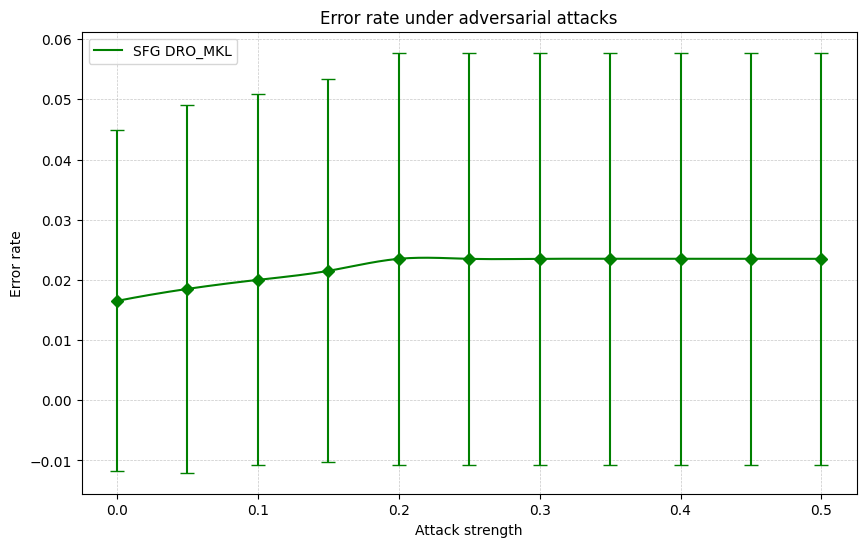

Error Rates under Adversarial Attacks:

Attack Strength		SFG DRO_MKL		
--------------------------------------------------
0.00			0.0165			
0.05			0.0185			
0.10			0.0200			
0.15			0.0215			
0.20			0.0235			
0.25			0.0235			
0.30			0.0235			
0.35			0.0235			
0.40			0.0235			
0.45			0.0235			
0.50			0.0235			


In [15]:
results = [results_sfg_MKL]

# Corresponding labels for the legend
labels = ['SFG DRO_MKL']

# Colors for the plot lines
colors = ['green', ]

# Markers for the error bar
markers = ['D', 's']  # D is for diamond shape, s is for square shape

# Title for the plot
title = 'Error rate under adversarial attacks'

# Call the function to plot error rates
plot_error_rates(results, labels, colors, markers, title)